# Demonstrating `stats` module

In this notebook we show the how to use and apply the classess and method in the `stats` module this include:
- Importing, selecting and changing probability distribution information of uncertain parameters
- global sensitivity analysis (GSA)
- Chance constraint optimization

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
sys.path.append('../develop_test')
import stats as pulpostats
import numpy as np
import pandas as pd

## 1. Defining the case

The case for which the sensitivity analysis will be performed for is on a solution of the LP:

$$
    \begin{align}
        & \underset{s, slack}{\text{min}}  && z_h \\
        & \text{s.t.}   && \sum_{j}(a_{i,j}\cdot s_j) = f_i && \forall i \\
        &               && s_j^{low} \leq s_j \leq s_j^{high} && \forall j \\
        &               && z_h = \sum_e \sum_j (q_{h,e}\cdot b_{e,j} \cdot s_j) && \forall h \\
    \end{align}
$$


### 1.1. Rice husk problem


In [ ]:
case_study = pulpostats.RiceHuskCase()
case_study.create_pulpo_worker()
case_study.define_problem()
result_data = case_study.solve_and_summarize(file_name="rice_husc_test")


### 1.2. Defining the electricity showcase problem

In [ ]:
case_study = pulpostats.ElectricityCase()
case_study.create_pulpo_worker()
case_study.define_problem()
result_data = case_study.solve_and_summarize(file_name='electricity_test')

### 1.3. Defining the Ammonia case study

In [2]:
case_study = pulpostats.AmmoniaCase()
case_study.create_pulpo_worker()
case_study.define_problem()
result_data = case_study.solve_and_summarize(file_name='ammonia_test')


Creating Instance
Instance created
Running HiGHS 1.8.0 (git hash: eda5cbe): Copyright (c) 2024 HiGHS under MIT licence terms
Cols:       47102 lower bounds    less than or equal to       -1e+20 are treated as -Infinity
Cols:       47102 upper bounds greater than or equal to        1e+20 are treated as +Infinity
Rows:       23537 lower bounds    less than or equal to       -1e+20 are treated as -Infinity
Rows:       23549 upper bounds greater than or equal to        1e+20 are treated as +Infinity
optimal solution found:  3881518178.900435


## Total Impact(s)

,Weight,Value
Method,,
"('IPCC 2021', 'climate change', 'GWP 100a, incl. H and bio CO2')",1,3.881518e+09


## Choices Made

### ammonia

,Value,Capacity
Metadata,,
"ammonia production, from nitrogen and hydrogen | ammonia production, from nitrogen and hydrogen | RER",2.010086e+09,1.000000e+20


### methane_market

,Value,Capacity
Metadata,,
"market group for natural gas, high pressure | natural gas, high pressure | Europe without Switzerland",2.095478e+09,1.000000e+20
market for bio methane | methane | RER,2.092156e+08,1.000000e+20


### hydrogen_market

,Value,Capacity
Metadata,,
"market for hydrogen, gaseous, low pressure | hydrogen, gaseous, low pressure | RER",2.034759e+08,1.000000e+20
market for hydrogen | hydrogen | RER,1.503000e+08,1.000000e+20


### ammonia_market

,Value,Capacity
Metadata,,
market for ammonia | ammonia | RER,3.000128e+09,1.000000e+20


### hydrogen

,Value,Capacity
Metadata,,
"hydrogen production, steam methane reforming, w/ CCS | hydrogen production, biomethane, with CCS | RER",150000000.0,150000000.0
"hydrogen production, plastics gasification, w/ CCS | hydrogen production, plastics gasification, with CCS | RER",300000.0,300000.0


### heat

,Value,Capacity
Metadata,,
heat from methane | heat from methane | RER,7.854816e+09,1.000000e+20
"heat from methane, w/ CCS | heat from biomethane, with CCS | RER",1.400000e+09,1.400000e+09


### biomethane

,Value,Capacity
Metadata,,
"biogas upgrading to biomethane, chemical scrubbing | biomethane, 24 bar | RER",1.351234e+08,1.000000e+20
"biogas upgrading to biomethane, chemical scrubbing w/ CCS | biomethane, 24 bar | RER",3.600000e+07,3.600000e+07
"biogas upgrading to biomethane, water scrubbing w/ CCS | biomethane, 24 bar | RER",3.600000e+07,3.600000e+07


## Constraints

### Constraints Upper

,Key,Metadata,Value,Limit
ID,,,,
23532,"(ammonia-reduced, a2610a42cd93afb46b13b2e95273...","anaerobic digestion of animal manure, with bio...",360000000.0,360000000.0


## 2. Filtering out negletable uncertain parameters

**Reformulating the problem for the sensitivity analysis**

We only consider uncertainty in the $B$ and $Q$ parameter matrizes. The scaling vector is given by the optimal solution.

We will look at the environmental impact objective:

$$
    e(Q, B) =  Q \cdot B \cdot s
$$

In [3]:
paramfilter = pulpostats.ParameterFilter(
    result_data=result_data, 
    lci_data=case_study.pulpo_worker.lci_data, 
    choices = case_study.choices,
    demand = case_study.demand,
    method = case_study.method
    )

Using the basic scaling vector which only includes the optimal choices in the scaling vector

In [4]:
scaling_vector_series = paramfilter.prepare_sampling(scaling_vector_strategy='naive')

Using the scaling vector constructed from all choices

In [5]:
scaling_vector_series = paramfilter.prepare_sampling(scaling_vector_strategy='constructed_demand')

Compute the LCA scores and return the characterized inventory to be used for the filtering

In [6]:
lca_score, characterized_inventory = paramfilter.compute_LCI_LCIA(scaling_vector_series)

chosen environmental impact method: ('IPCC 2021', 'climate change', 'GWP 100a, incl. H and bio CO2')
The total impact is: 5.426719e+01


Plot the largest contributors

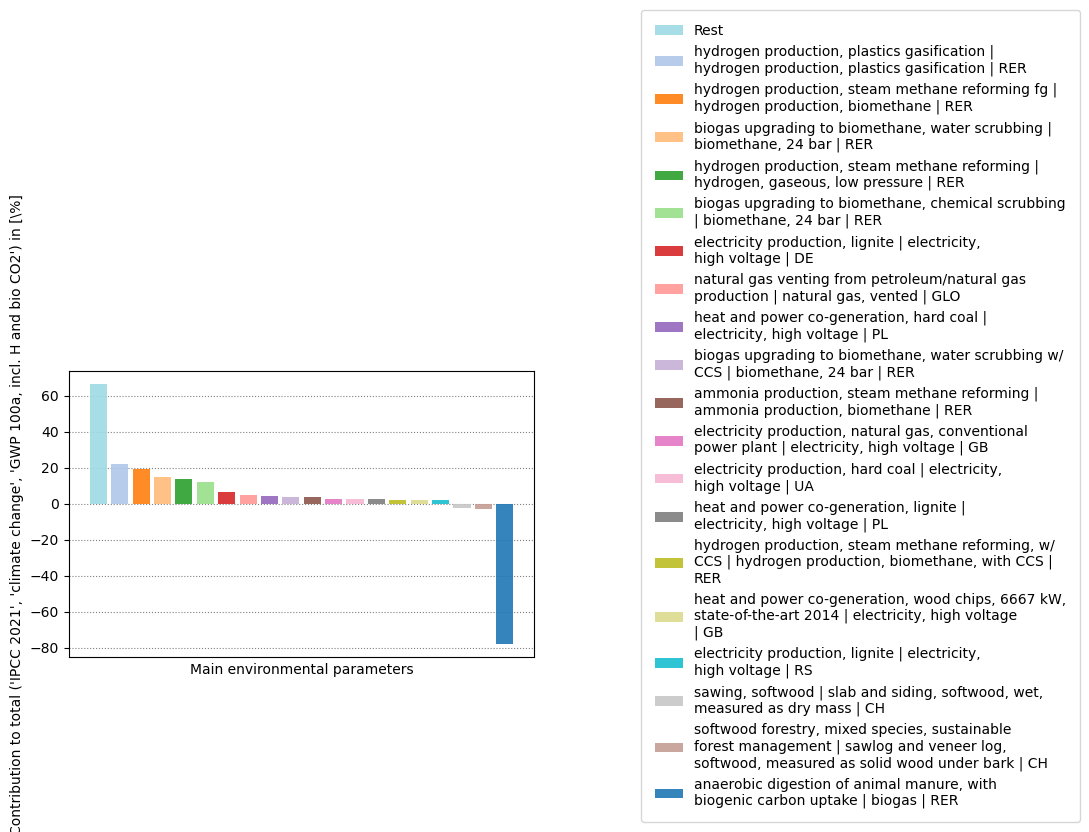

In [7]:
paramfilter.plot_top_processes(characterized_inventory, top_amount=19)

Filtering out the inventoryflows $B_{i,j}$ that have a neglectable impact

In [ ]:
cutoff = 0.000019 # ATTN: Change to 0. to include all parameters, this is needed to include the CCS biosphere flows else they are filtered out
filtered_inventory_indcs = paramfilter.filter_inventoryflows(characterized_inventory, lca_score, cutoff)

Characterized inventory: (2648, 23557) 26581
Filtered characterized inventory: (2648, 23557) 1009
Deviation from LCA score: 0.009507277234347966
inventory (2648, 23557) filtering resulted in 1009 of 26581 exchanges (99.05% of total impact) and took 0.018 seconds.


In [24]:
filtered_characterization_indcs = paramfilter.filter_characterization_factors(filtered_inventory_indcs)

CHARACTERIZATION MATRIX (2648,) filtering resulted in 27 of 111 characterization factors


## 3. Getting the uncertainty of the parameter values

### 3.1. Interventions flows

Extract the metadata containing the uncertainty information to the filtered intervention flows and seperate the metadata into the parameters with and without defined uncertainty information

In [25]:
uncertainty_importer = pulpostats.UncertaintyImporter(lci_data=case_study.pulpo_worker.lci_data)
backgroundDB_filtInv_indcs = uncertainty_importer.get_intervention_indcs_to_db('ecoinvent-3.10-cutoff', filtered_inventory_indcs)
foregroundDB_filtInv_indcs = uncertainty_importer.get_intervention_indcs_to_db('ammonia-reduced', filtered_inventory_indcs)
bg_inventory_metadata_df = uncertainty_importer.get_if_meta(inventory_indices=backgroundDB_filtInv_indcs)
fg_inventory_metadata_df = uncertainty_importer.get_if_meta(inventory_indices=foregroundDB_filtInv_indcs)
bg_inventory_defined,  bg_inventory_undefined = uncertainty_importer.separate(bg_inventory_metadata_df)
fg_inventory_defined,  fg_inventory_undefined = uncertainty_importer.separate(fg_inventory_metadata_df)


Parameters with uncertainty information: 886 
Parameters without uncertainty information: 96
Parameters with uncertainty information: 0 
Parameters without uncertainty information: 27


Apply the triangular strategy using bound interpolation to the missing intervention uncertainty parameters in the background database

upper spread statistics
mean: 0.9626
mode: 0    3.466758
dtype: float64
median: 0.5730
std: 1.1357
min: 0.0582
max: 8.0184


lower spread statistics
mean: 0.3940
mode: 0    0.776124
dtype: float64
median: 0.3643
std: 0.1831
min: 0.0550
max: 0.8891

The upper spread scaling factor for intervention flows is: 0.5730084843433487
The lower spread scaling factor for intervention flows is: 0.3642755182787799
uncertain parameters with negative median value:
            input  output  type  uncertainty_type      amount         loc  \
row  col                                                                    
2129 1603    3721    5966     2                 5 -186.611023 -186.611023   
     4358    3721    8721     2                 5 -493.676880 -493.676880   
     10497   3721   14860     2                 5 -493.676880 -493.676880   
     11086   3721   15449     2                 5 -648.320374 -648.320374   
     12978   3721   17341     2                 5 -185.861328 -185.861328   
     17

/Users/hausslingbhl/Library/CloudStorage/OneDrive-UniversiteitLeiden/13_Code/03_Chapter_3/pulpo_flechtenberg/pulpo/develop_tests/stats.py:1278: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.322629154931059' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  metadata_df.loc[undefined_indx, 'maximum'] = amount + upper_scaling_fac * abs(amount)
/Users/hausslingbhl/Library/CloudStorage/OneDrive-UniversiteitLeiden/13_Code/03_Chapter_3/pulpo_flechtenberg/pulpo/develop_tests/stats.py:1279: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.757274962447677' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  metadata_df.loc[undefined_indx, 'minimum'] = amount - lower_scaling_fac * abs(amount)


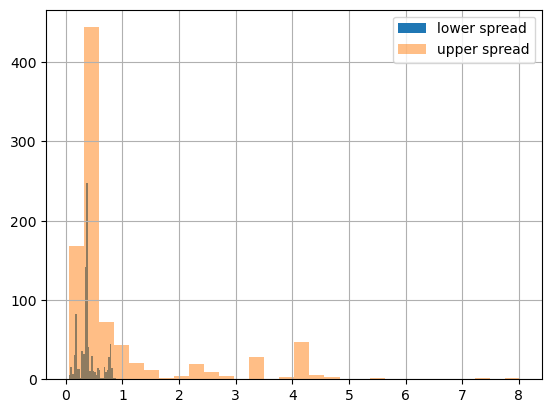

In [26]:
if_bg_triangular_strategy = pulpostats.TriangularBoundInterpolationStrategy(
    metadata_df=bg_inventory_metadata_df,
    undefined_uncertainty_indices= bg_inventory_undefined,
    defined_uncertainty_metadata=bg_inventory_defined,
    noise_interval={'min':.1, 'max':.1}
    )

Apply the Uniform strategy for the uncertainty parameters in the foreground database

In [27]:
if_fg_uniform_strategy = pulpostats.UniformBaseStrategy(
    metadata_df=fg_inventory_metadata_df,
    undefined_uncertainty_indices=fg_inventory_undefined,
    upper_scaling_factor = .5,
    lower_scaling_factor = .5,
    noise_interval={'min':.2, 'max':.2}
)

/Users/hausslingbhl/Library/CloudStorage/OneDrive-UniversiteitLeiden/13_Code/03_Chapter_3/pulpo_flechtenberg/pulpo/develop_tests/stats.py:1185: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.014937218878419518' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  metadata_df.loc[undefined_indx, 'maximum'] = amount + upper_scaling_factor * abs(amount)
/Users/hausslingbhl/Library/CloudStorage/OneDrive-UniversiteitLeiden/13_Code/03_Chapter_3/pulpo_flechtenberg/pulpo/develop_tests/stats.py:1186: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.005062780674545646' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  metadata_df.loc[undefined_indx, 'minimum'] = amount - lower_scaling_factor * abs(amount)


In [28]:
if_fg_uniform_strategy.rename_metadata_index(case_study.pulpo_worker.lci_data, 'intervention_flow')


,row,col,input,output,type,uncertainty_type,amount,loc,scale,shape,minimum,maximum,negative
"carbon dioxide storage and transport 200 km pipeline, storage 1000 m | carbon dioxide storage and transport 200 km pipeline, storage 1000 m | RER --- Carbon dioxide, fossil | ('air', 'urban air close to ground')",80,23548,107,28128,2,4,0.010000,NaN,NaN,NaN,0.005063,0.014937,False
"anaerobic digestion of animal manure, with biogenic carbon uptake | biogas | RER --- Carbon dioxide, in air | ('natural resource', 'in air')",81,23532,108,28111,2,4,2.444555,NaN,NaN,NaN,1.113116,3.775994,False
"ammonia production, steam methane reforming | ammonia production, biomethane | RER --- Carbon dioxide, non-fossil | ('air', 'urban air close to ground')",82,23524,109,28103,2,4,1.432585,NaN,NaN,NaN,0.791420,2.073750,False
"heat from methane, w/ CCS | heat from biomethane, with CCS | RER --- Carbon dioxide, non-fossil | ('air', 'urban air close to ground')",82,23552,109,28132,2,4,0.005895,NaN,NaN,NaN,0.003229,0.008561,False
"ammonia production, steam methane reforming, w/ CCS | ammonia production, biomethane, with CCS | RER --- Carbon dioxide, non-fossil | ('air', 'urban air close to ground')",82,23553,109,28133,2,4,0.004871,NaN,NaN,NaN,0.002350,0.007391,False
"heat from methane | heat from methane | RER --- Carbon dioxide, non-fossil | ('air', 'urban air close to ground')",82,23556,109,28189,2,4,0.058947,NaN,NaN,NaN,0.033327,0.084567,False
"biogas upgrading to biomethane, water scrubbing | biomethane, 24 bar | RER --- Carbon dioxide, non-fossil | ('air', 'non-urban air or from high stacks')",714,23523,1028,28102,2,4,1.445824,NaN,NaN,NaN,0.638465,2.253182,False
"biogas upgrading to biomethane, water scrubbing w/ CCS | biomethane, 24 bar | RER --- Carbon dioxide, non-fossil | ('air', 'non-urban air or from high stacks')",714,23529,1028,28108,2,4,0.029811,NaN,NaN,NaN,0.016438,0.043183,False
"anaerobic digestion of animal manure, with biogenic carbon uptake | biogas | RER --- Carbon dioxide, non-fossil | ('air', 'non-urban air or from high stacks')",714,23532,1028,28111,2,4,0.524958,NaN,NaN,NaN,0.266699,0.783218,False
"biogas upgrading to biomethane, chemical scrubbing | biomethane, 24 bar | RER --- Carbon dioxide, non-fossil | ('air', 'non-urban air or from high stacks')",714,23542,1028,28121,2,4,1.478006,NaN,NaN,NaN,0.727602,2.228410,False


Set expert judgement uncertainties to a few selected intervention flows:

In [29]:
# ATTN: It might be better to not call an index directly but search for the process and the intervention flow, just not sure how
# This can be done in a step before which returns the indices and can be called like defined here
CCS_expert_uncertainty_info = {
    (80, 23548): {'minimum':.01 ,'maximum':.5, 'uncertainty_type':4}, # carbon dioxide storage and transport 200 km pipeline, storage 1000 m | carbon dioxide storage and transport 200 km pipeline, storage 1000 m | RER --- Carbon dioxide, fossil | ('air', 'urban air close to ground')
    (80, 23538): {'minimum':.0002 ,'maximum':.002, 'uncertainty_type':4}, # transport, pipeline, supercritical carbon dioxide, 200 km without recompression | transport, pipeline, supercritical carbon dioxide, 200 km without recompression | RER --- Carbon dioxide, fossil | ('air', 'urban air close to ground')
    }
if_fg_expert_knowledge_strategy = pulpostats.ExpertKnowledgeStrategy(
    if_fg_uniform_strategy.metadata_assigned_df,
    CCS_expert_uncertainty_info.keys(),
    CCS_expert_uncertainty_info
)

Check if the uncertainty data has been assgined correctly to the flows

In [30]:
if_fg_expert_knowledge_strategy.rename_metadata_index(case_study.pulpo_worker.lci_data, 'intervention_flow')

,row,col,input,output,type,uncertainty_type,amount,loc,scale,shape,minimum,maximum,negative
"carbon dioxide storage and transport 200 km pipeline, storage 1000 m | carbon dioxide storage and transport 200 km pipeline, storage 1000 m | RER --- Carbon dioxide, fossil | ('air', 'urban air close to ground')",80,23548,107.0,28128.0,2.0,4.0,0.010000,NaN,NaN,NaN,0.010000,0.500000,False
"anaerobic digestion of animal manure, with biogenic carbon uptake | biogas | RER --- Carbon dioxide, in air | ('natural resource', 'in air')",81,23532,108.0,28111.0,2.0,4.0,2.444555,NaN,NaN,NaN,1.113116,3.775994,False
"ammonia production, steam methane reforming | ammonia production, biomethane | RER --- Carbon dioxide, non-fossil | ('air', 'urban air close to ground')",82,23524,109.0,28103.0,2.0,4.0,1.432585,NaN,NaN,NaN,0.791420,2.073750,False
"heat from methane, w/ CCS | heat from biomethane, with CCS | RER --- Carbon dioxide, non-fossil | ('air', 'urban air close to ground')",82,23552,109.0,28132.0,2.0,4.0,0.005895,NaN,NaN,NaN,0.003229,0.008561,False
"ammonia production, steam methane reforming, w/ CCS | ammonia production, biomethane, with CCS | RER --- Carbon dioxide, non-fossil | ('air', 'urban air close to ground')",82,23553,109.0,28133.0,2.0,4.0,0.004871,NaN,NaN,NaN,0.002350,0.007391,False
"heat from methane | heat from methane | RER --- Carbon dioxide, non-fossil | ('air', 'urban air close to ground')",82,23556,109.0,28189.0,2.0,4.0,0.058947,NaN,NaN,NaN,0.033327,0.084567,False
"biogas upgrading to biomethane, water scrubbing | biomethane, 24 bar | RER --- Carbon dioxide, non-fossil | ('air', 'non-urban air or from high stacks')",714,23523,1028.0,28102.0,2.0,4.0,1.445824,NaN,NaN,NaN,0.638465,2.253182,False
"biogas upgrading to biomethane, water scrubbing w/ CCS | biomethane, 24 bar | RER --- Carbon dioxide, non-fossil | ('air', 'non-urban air or from high stacks')",714,23529,1028.0,28108.0,2.0,4.0,0.029811,NaN,NaN,NaN,0.016438,0.043183,False
"anaerobic digestion of animal manure, with biogenic carbon uptake | biogas | RER --- Carbon dioxide, non-fossil | ('air', 'non-urban air or from high stacks')",714,23532,1028.0,28111.0,2.0,4.0,0.524958,NaN,NaN,NaN,0.266699,0.783218,False
"biogas upgrading to biomethane, chemical scrubbing | biomethane, 24 bar | RER --- Carbon dioxide, non-fossil | ('air', 'non-urban air or from high stacks')",714,23542,1028.0,28121.0,2.0,4.0,1.478006,NaN,NaN,NaN,0.727602,2.228410,False


### 3.2. Characterization factors

Extract the metadata containing the uncertainty information to the filtered characterization factors and seperate the metadata into the parameters with and without defined uncertainty information

In [31]:
characterization_metadata_df = uncertainty_importer.get_cf_meta(
    characterization_indices=filtered_characterization_indcs,
    method=case_study.method
    )
cf_defined,  cf_undefined = uncertainty_importer.separate(characterization_metadata_df)

Parameters with uncertainty information: 0 
Parameters without uncertainty information: 27


Apply the triangular strategy using predefined scaling factors to the missing uncertainty parameters

In [32]:
upper_scaling_factor_cf = 0.15
lower_scaling_factor_cf = 0.15
cf_triangular_strategy = pulpostats.TriangluarBaseStrategy(
    metadata_df=characterization_metadata_df,
    undefined_uncertainty_indices=cf_undefined,
    upper_scaling_factor = upper_scaling_factor_cf,
    lower_scaling_factor = lower_scaling_factor_cf,
    noise_interval={'min':.1, 'max':.1}
)

uncertain parameters with negative median value:
      flow  geo         col  uncertainty_type  amount  loc  scale  shape  \
row                                                                        
81     108    1  4294967295                 5    -1.0 -1.0    NaN    NaN   
2129  3721    1  4294967295                 5    -1.0 -1.0    NaN    NaN   

       minimum   maximum  negative  
row                                 
81   -1.156698 -0.843302      True  
2129 -1.152857 -0.847143      True  


/Users/hausslingbhl/Library/CloudStorage/OneDrive-UniversiteitLeiden/13_Code/03_Chapter_3/pulpo_flechtenberg/pulpo/develop_tests/stats.py:1278: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1490582881843858' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  metadata_df.loc[undefined_indx, 'maximum'] = amount + upper_scaling_fac * abs(amount)
/Users/hausslingbhl/Library/CloudStorage/OneDrive-UniversiteitLeiden/13_Code/03_Chapter_3/pulpo_flechtenberg/pulpo/develop_tests/stats.py:1279: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8509417118156142' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  metadata_df.loc[undefined_indx, 'minimum'] = amount - lower_scaling_fac * abs(amount)


### 3.3. Variable bounds

Defining the uncertainty information for the variable bounds

Extract all the variable bounds for the choices as defined in the case study

In [33]:
var_bound_params = {}
for choice, alternatives in case_study.choices.items():
    for alternative, upperbound in alternatives.items():
        alternative_indx = case_study.pulpo_worker.lci_data['process_map'][alternative.key]
        var_bound_params[alternative_indx] = alternative.as_dict()

In [34]:
var_upper_bound_metadata_df = uncertainty_importer.get_pyomo_param_meta(
    case_study.pulpo_worker.instance, 
    'UPPER_LIMIT', 
    list(var_bound_params.keys())
    )
var_upper_bound_defined,  var_upper_bound_undefined = uncertainty_importer.separate(var_upper_bound_metadata_df)


Parameters with uncertainty information: 0 
Parameters without uncertainty information: 20


In [37]:
# ATTN: Not included additional constraints as an example here yet.

Apply triangular uncertainty strategy with upper and lower scaling factor to the variable bounds (any other strategy is also possible)

In [35]:
var_bound_upper_strategy = pulpostats.TriangluarBaseStrategy(
    var_upper_bound_metadata_df,
    var_upper_bound_undefined,
    .1,
    .5,
    {'min':.2, 'max':.1}
)

uncertain parameters with negative median value:
Empty DataFrame
Columns: [amount, uncertainty_type, loc, maximum, minimum]
Index: []


### 3.4. Combine all the uncertainty information into `unc_metadata` object

In [36]:
# ATTN: Define this dict in more detail, that it mey only contain keys which are Vars or Params in the pyomo instance
unc_metadata = {
    'cf': cf_triangular_strategy.metadata_assigned_df, # ATTN: change key to pyomo name
    'if': pd.concat([ # ATTN: change key to pyomo name
        # Takes the 'if_fg_expert_knowledge_strategy' since it contains teh updated metadata from 'if_fg_uniform_strategy'
        if_fg_expert_knowledge_strategy.metadata_assigned_df, 
        if_bg_triangular_strategy.metadata_assigned_df
        ]),
    'UPPER_LIMIT': var_bound_upper_strategy.metadata_assigned_df
}

## 4. Define the global sensitivity problem
### 4.1. Define the bound/interval of the parameters

Check if all parameters have gotten uncertainty information asigned

In [ ]:
from SALib.sample import sobol as sample_method
from SALib.analyze import sobol as SA_method
N = 2**3

gsa = pulpostats.GlobalSensitivityAnalysis(
    result_data=result_data,
    lci_data=case_study.pulpo_worker.lci_data,
    unc_metadata=unc_metadata,
    sampler=sample_method,
    analyser=SA_method,
    sample_size=N,
    method=case_study.method
)
gsa_problem, all_bounds_indx_dict = gsa.define_problem()

In [ ]:
sample_data_if, sample_data_cf = gsa.sample(gsa_problem, all_bounds_indx_dict)

In [ ]:
sample_impacts, sample_characterized_inventories = gsa.run_model(sample_data_if, sample_data_cf)

In [ ]:
total_Si = gsa.analyze(gsa_problem, sample_impacts)

In [ ]:
total_Si_metadata = gsa.generate_Si_metadata(all_bounds_indx_dict, total_Si)
colormap_base, colormap_SA_barplot = gsa.plot_top_total_sensitivity_indices(total_Si, total_Si_metadata)

In [ ]:
data_plot = gsa.plot_total_env_impact_contribution(
    sample_characterized_inventories, 
    total_Si_metadata, 
    colormap_base=colormap_base, 
    colormap_SA_barplot=colormap_SA_barplot,
    )

## 5. CC formulation

There are different ways to formulate the chance constrain optimization problem:
- CC the objectives (uncertainties in the environmental costs)
- CC the variable bounds (also only individual bounds can be chance constrained):
    - scaling variable bounds (`UPPER_LIMT` and `LOWER_LIMIT`)
    - Inventory limit (`UPPER_INV_LIMIT` and `UPPER_IMP_LIMIT`)

These can be combined or used seperately. They are represented by different `CCFormulation` classes which inherit from eachother.

The chance constraints can only be applied if the corresponding parameters have true uncertainty information specified.


### 5.1. CC Objective formulation

27 parameters with non normal distribution are transformed into normal distributions via max likelihood approximation
1007 parameters with non normal distribution are transformed into normal distributions via max likelihood approximation
20 parameters with non normal distribution are transformed into normal distributions via max likelihood approximation
These environmental costs have a standard deviation larger than 50% of their mean:

            std                                           metadata      mean  \
19807  0.144788  rape oil mill operation | rape oil, crude | Eu...  0.000037   
19808  0.034178  rape oil mill operation | rape meal | Europe w...  0.000009   
23548  0.141686  carbon dioxide storage and transport 200 km pi...  0.010000   
21319  0.149265    rape oil mill operation | rape oil, crude | RoW  0.013270   
21320  0.035236          rape oil mill operation | rape meal | RoW  0.003133   
...         ...                                                ...       ...   


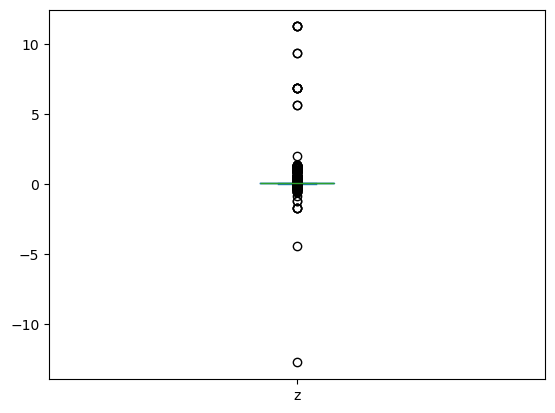

In [ ]:
cc_Obj_formulation = pulpostats.CCFormulationObjL1(
    unc_metadata=unc_metadata,
    pulpo_worker=case_study.pulpo_worker,
    method=case_study.method,
    choices=case_study.choices
)

### 5.2. CC Variable bounds formulation

20 parameters with non normal distribution are transformed into normal distributions via max likelihood approximation


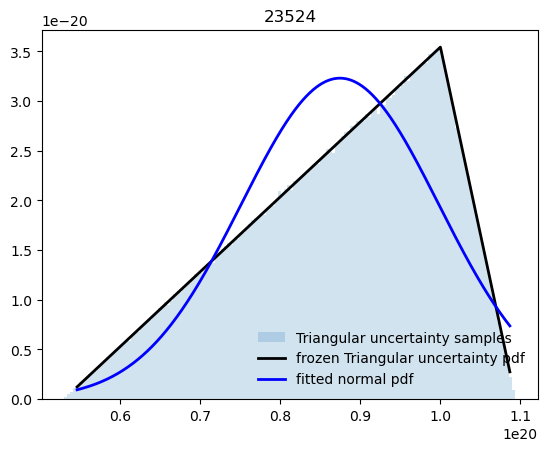

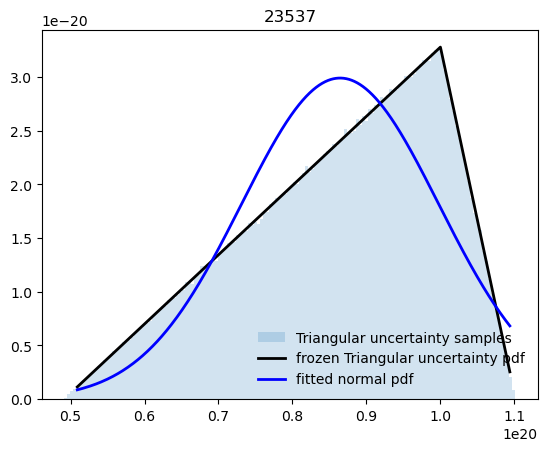

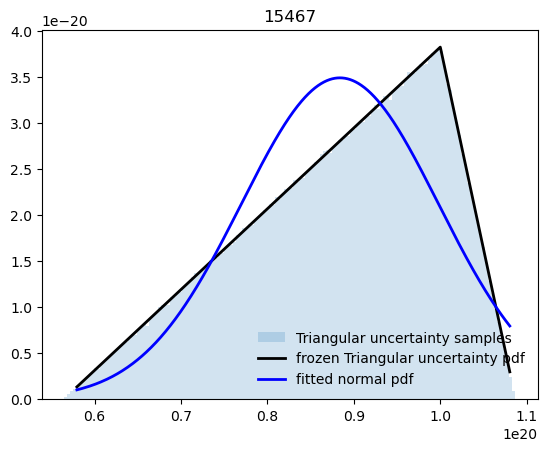

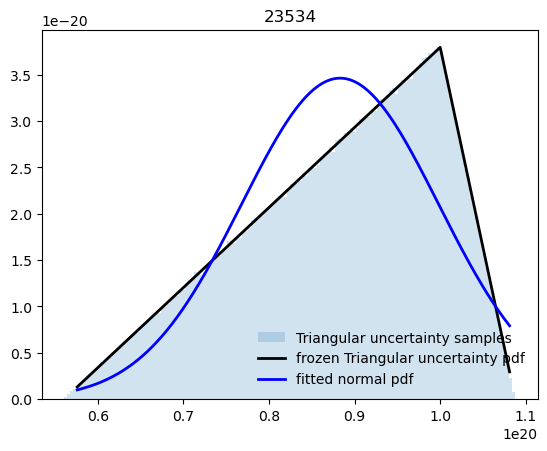

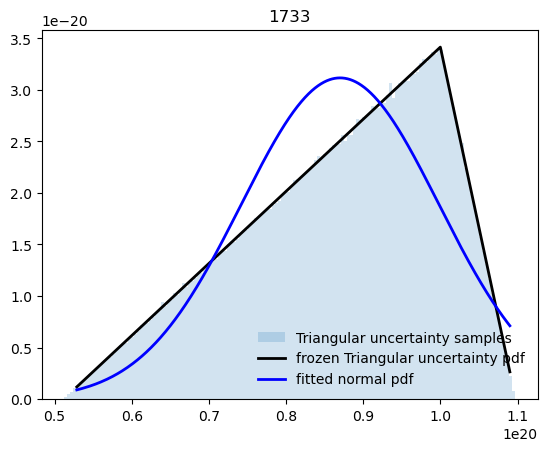

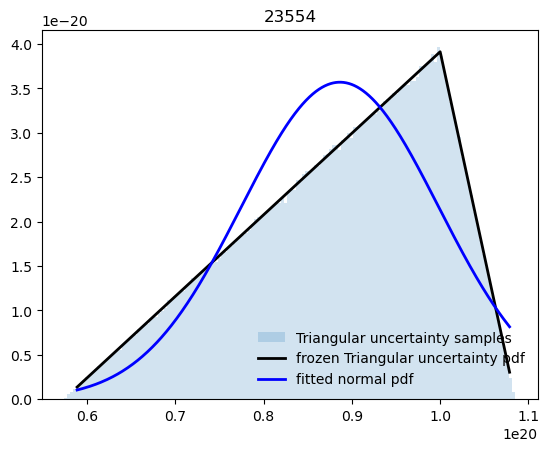

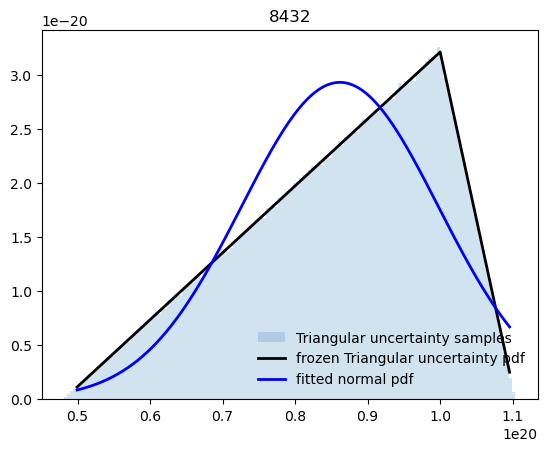

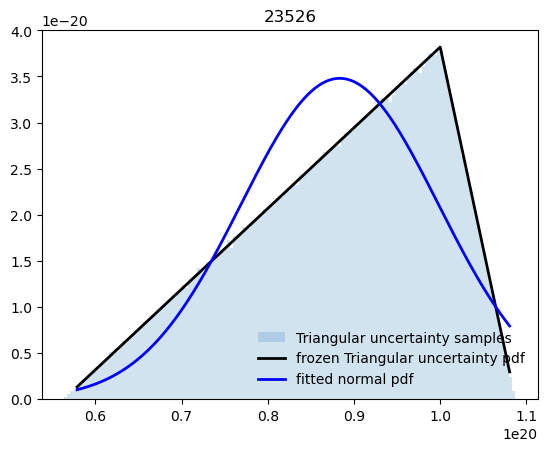

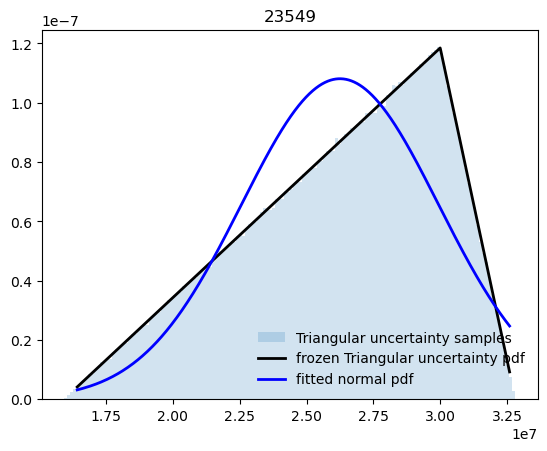

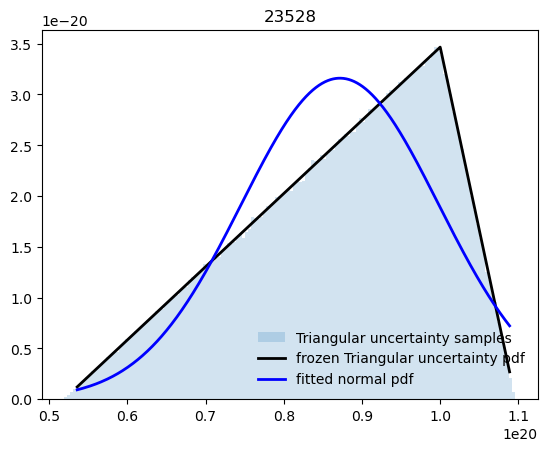

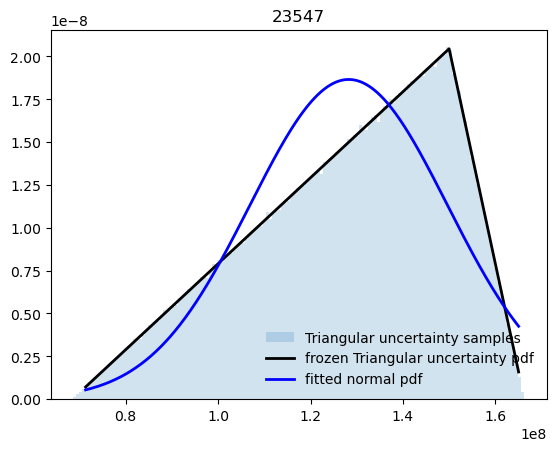

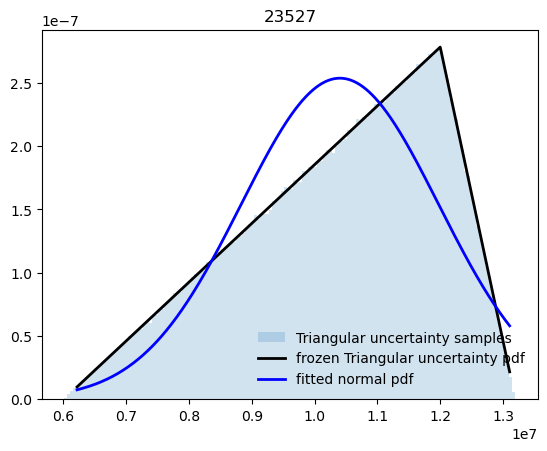

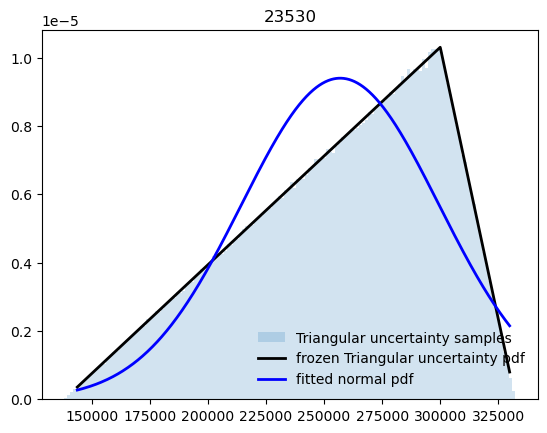

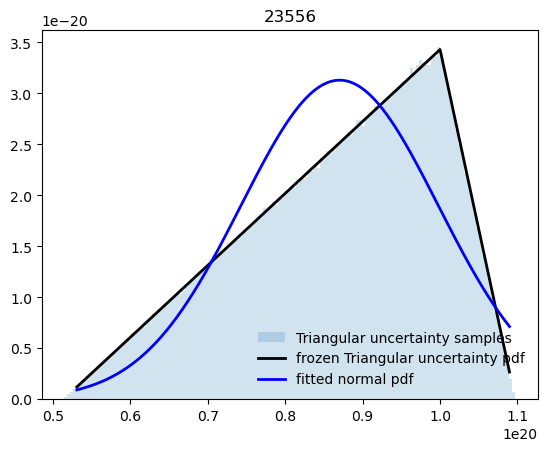

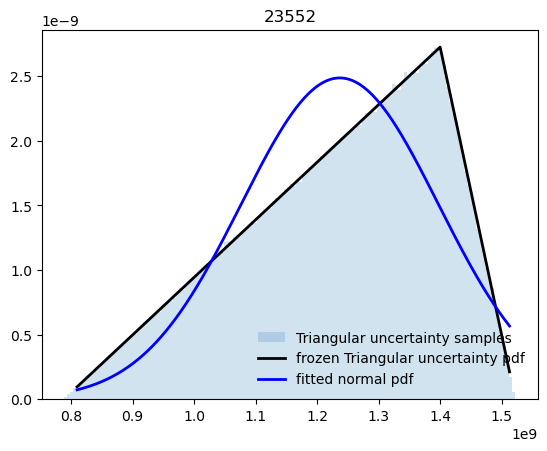

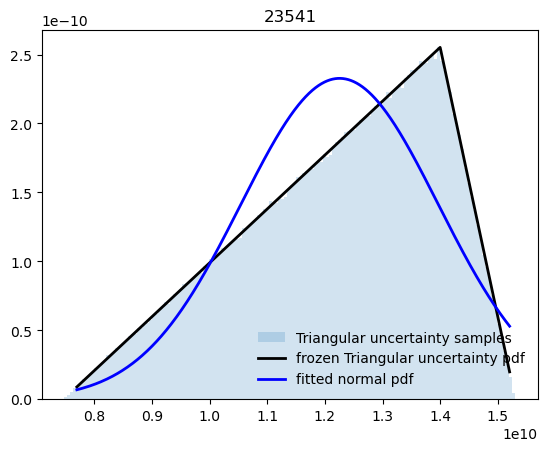

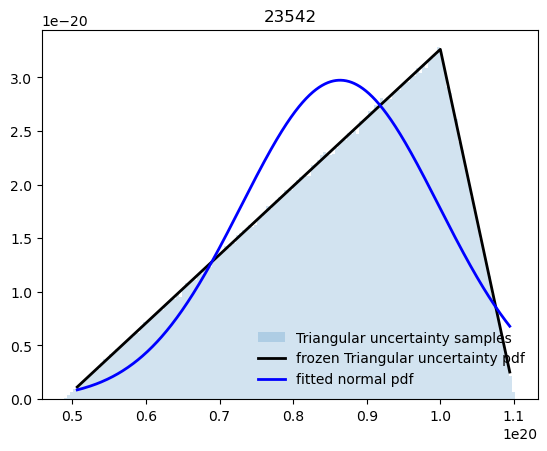

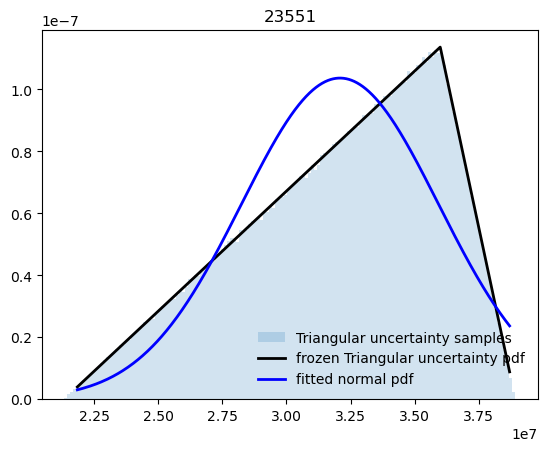

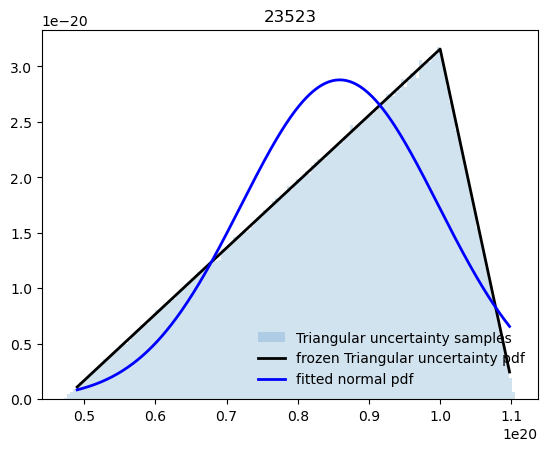

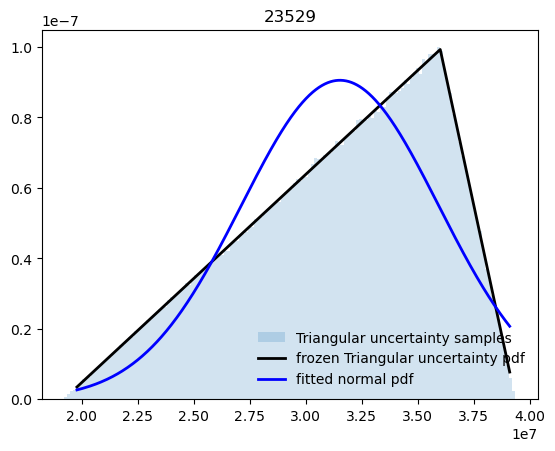

In [53]:
cc_varbounds_formulation = pulpostats.CCFormulationVarBounds(
    unc_metadata={'UPPER_LIMIT':unc_metadata['UPPER_LIMIT']},
    pulpo_worker=case_study.pulpo_worker,
    method=case_study.method,
    choices=case_study.choices,
    plot_normal_fit_distribution=True
)

### 5.3. CC Objective and Variable bounds formulation

27 parameters with non normal distribution are transformed into normal distributions via max likelihood approximation
1007 parameters with non normal distribution are transformed into normal distributions via max likelihood approximation
20 parameters with non normal distribution are transformed into normal distributions via max likelihood approximation
These environmental costs have a standard deviation larger than 50% of their mean:

            std                                           metadata      mean  \
19807  0.144820  rape oil mill operation | rape oil, crude | Eu...  0.000037   
19808  0.034186  rape oil mill operation | rape meal | Europe w...  0.000009   
23548  0.141633  carbon dioxide storage and transport 200 km pi...  0.010000   
21319  0.149299    rape oil mill operation | rape oil, crude | RoW  0.013270   
21320  0.035243          rape oil mill operation | rape meal | RoW  0.003133   
...         ...                                                ...       ...   


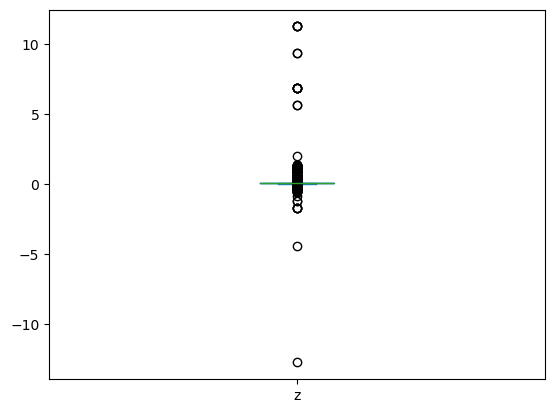

In [ ]:
cc_Obj_varbounds_formulation = pulpostats.CCFormulationObjL1VarBound(
    unc_metadata=unc_metadata,
    pulpo_worker=case_study.pulpo_worker,
    method=case_study.method,
    choices=case_study.choices
)

## 6. Pareto Optimization

The CC problem is solved as a Pareto optimization using on environmental impact category and the probability level underlying the chance constraints.

Initiate epsilon solver for the Pareto Problem

In [ ]:
epsilon_pareto_solver = pulpostats.EpsilonConstraintSolver(cc_Obj_formulation)

Solve single Pareto point

In [ ]:
CC_solution = epsilon_pareto_solver.solve_single_pareto_point(lambda_level=.5)
epsilon_pareto_solver.cc_formulation.pulpo_worker.summarize_results()

Solve for an array of lambda epsilon constraints

In [ ]:
lambda_epsilon_array = np.linspace(0.5,1, 5, endpoint=False)
CC_solutions = epsilon_pareto_solver.solve(lambda_epsilon_array)

Plot Pareto front

In [ ]:
epsilon_pareto_solver.plot_pareto_front(CC_solutions, 0.005, bbox_to_anchor=(0.65,-1.8))

Compare the Pareto points

In [ ]:
epsilon_pareto_solver.compare_subsequent_paretosolutions(CC_solutions)

## 7. Pareto front case studies

### 7.1. More detailled Pareto Front

In [ ]:
lambda_epsilon_array = np.linspace(0.5,1, 20, endpoint=False)
CC_solutions_20p = epsilon_pareto_solver.solve(lambda_epsilon_array)
epsilon_pareto_solver.plot_pareto_front(CC_solutions_20p, 0.005, bbox_to_anchor=(0.65,-1.8))
epsilon_pareto_solver.compare_subsequent_paretosolutions(CC_solutions_20p)

### 7.2. Cance constraining only the scaling vector variable bounds of the choices

solving CC problem for lambda_QB = 0.5
Running HiGHS 1.8.0 (git hash: eda5cbe): Copyright (c) 2024 HiGHS under MIT licence terms
Cols:       47102 lower bounds    less than or equal to       -1e+20 are treated as -Infinity
Cols:       47102 upper bounds greater than or equal to        1e+20 are treated as +Infinity
Rows:       23537 lower bounds    less than or equal to       -1e+20 are treated as -Infinity
Rows:       23537 upper bounds greater than or equal to        1e+20 are treated as +Infinity
optimal solution found:  4037254641.900535
solving CC problem for lambda_QB = 0.6
Running HiGHS 1.8.0 (git hash: eda5cbe): Copyright (c) 2024 HiGHS under MIT licence terms
Cols:       47102 lower bounds    less than or equal to       -1e+20 are treated as -Infinity
Cols:       47102 upper bounds greater than or equal to        1e+20 are treated as +Infinity
Rows:       23537 lower bounds    less than or equal to       -1e+20 are treated as -Infinity
Rows:       23537 upper bounds greater th

'ammonia'

,Capacity,0.5,0.6,0.7,0.8,0.9
Metadata,,,,,,
"ammonia production, from nitrogen and hydrogen | ammonia production, from nitrogen and hydrogen | RER",1.000000e+20,2.010086e+09,2.010086e+09,2.010086e+09,2.010086e+09,2.010086e+09
"ammonia production, steam methane reforming | ammonia production, biomethane | RER",1.000000e+20,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00


'methane_market'

,Capacity,0.5,0.6,0.7,0.8,0.9
Metadata,,,,,,
"market group for natural gas, high pressure | natural gas, high pressure | Europe without Switzerland",1.000000e+20,2.086218e+09,2.083911e+09,2.081442e+09,2.078553e+09,2.074546e+09
market for bio methane | methane | RER,1.000000e+20,2.092083e+08,2.092065e+08,2.092046e+08,2.092023e+08,2.091992e+08


'hydrogen_market'

,Capacity,0.5,0.6,0.7,0.8,0.9
Metadata,,,,,,
"market for hydrogen, gaseous, low pressure | hydrogen, gaseous, low pressure | RER",1.000000e+20,2.252538e+08,2.306814e+08,2.364883e+08,2.432843e+08,2.527092e+08
market for hydrogen | hydrogen | RER,1.000000e+20,1.285221e+08,1.230945e+08,1.172876e+08,1.104916e+08,1.010667e+08


'ammonia_market'

,Capacity,0.5,0.6,0.7,0.8,0.9
Metadata,,,,,,
market for ammonia | ammonia | RER,1.000000e+20,3.000128e+09,3.000128e+09,3.000128e+09,3.000128e+09,3.000128e+09
"market for ammonia, anhydrous, liquid | ammonia, anhydrous, liquid | RER",1.000000e+20,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00


'hydrogen'

,Capacity,0.5,0.6,0.7,0.8,0.9
Metadata,,,,,,
"hydrogen production, steam methane reforming, w/ CCS | hydrogen production, biomethane, with CCS | RER",1.500000e+08,1.282652e+08,1.228483e+08,1.170529e+08,1.102704e+08,1.008642e+08
"hydrogen production, plastics gasification, w/ CCS | hydrogen production, plastics gasification, with CCS | RER",3.000000e+05,2.569450e+05,2.461890e+05,2.346813e+05,2.212136e+05,2.025361e+05
"hydrogen production, PEM electrolysis, yellow | hydrogen production, PEM electrolysis, green | RER",3.000000e+07,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00
"hydrogen production, steam methane reforming fg | hydrogen production, biomethane | RER",1.000000e+20,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00
"hydrogen production, plastics gasification | hydrogen production, plastics gasification | RER",1.200000e+07,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00


'heat'

,Capacity,0.5,0.6,0.7,0.8,0.9
Metadata,,,,,,
heat from methane | heat from methane | RER,1.000000e+20,8.018029e+09,8.058678e+09,8.102168e+09,8.153066e+09,8.223652e+09
"heat from methane, w/ CCS | heat from biomethane, with CCS | RER",1.400000e+09,1.236787e+09,1.196138e+09,1.152648e+09,1.101750e+09,1.031164e+09
heat from hydrogen | heat from hydrogen | RER,1.400000e+10,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00


'biomethane'

,Capacity,0.5,0.6,0.7,0.8,0.9
Metadata,,,,,,
"biogas upgrading to biomethane, chemical scrubbing | biomethane, 24 bar | RER",1.000000e+20,1.435019e+08,1.455917e+08,1.478276e+08,1.504444e+08,1.540733e+08
"biogas upgrading to biomethane, chemical scrubbing w/ CCS | biomethane, 24 bar | RER",3.600000e+07,3.208796e+07,3.111267e+07,3.006921e+07,2.884802e+07,2.715445e+07
"biogas upgrading to biomethane, water scrubbing w/ CCS | biomethane, 24 bar | RER",3.600000e+07,3.152638e+07,3.041004e+07,2.921569e+07,2.781790e+07,2.587942e+07
"biogas upgrading to biomethane, water scrubbing | biomethane, 24 bar | RER",1.000000e+20,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00


lambda_1: 0.5
lambda_2: 0.6

Amount of process scaling variables that changed:
1031: >1% 
62: >10%
31: >100%
5: >1000%

Amount of process characterized scaling variables (impacts per process) that changed:
1: >1% 
0: >10%
0: >100%
0: >1000%

1.01290e-02: is the maximum impact change in one process
1.39394e-02: is the total impact change

The relative change of the characterized scaling vector (s_lambda_1 - s_lambda_2)*QB_s / QBs:



ID
hydrogen production, steam methane reforming | hydrogen, gaseous, low pressure | RER                                                                 0.010129
hydrogen production, steam methane reforming, w/ CCS | hydrogen production, biomethane, with CCS | RER                                               0.001122
biogas upgrading to biomethane, chemical scrubbing | biomethane, 24 bar | RER                                                                        0.000776
heat from methane | heat from methane | RER                                                                                                          0.000594
biogas upgrading to biomethane, water scrubbing w/ CCS | biomethane, 24 bar | RER                                                                    0.000125
carbon dioxide storage and transport 200 km pipeline, storage 1000 m | carbon dioxide storage and transport 200 km pipeline, storage 1000 m | RER    0.000114
heat from methane, w/ CCS | heat from biomethane,


---

lambda_1: 0.6
lambda_2: 0.7

Amount of process scaling variables that changed:
1128: >1% 
57: >10%
15: >100%
2: >1000%

Amount of process characterized scaling variables (impacts per process) that changed:
1: >1% 
0: >10%
0: >100%
0: >1000%

1.07337e-02: is the maximum impact change in one process
1.47716e-02: is the total impact change

The relative change of the characterized scaling vector (s_lambda_1 - s_lambda_2)*QB_s / QBs:



ID
hydrogen production, steam methane reforming | hydrogen, gaseous, low pressure | RER                                                                 0.010734
hydrogen production, steam methane reforming, w/ CCS | hydrogen production, biomethane, with CCS | RER                                               0.001189
biogas upgrading to biomethane, chemical scrubbing | biomethane, 24 bar | RER                                                                        0.000822
heat from methane | heat from methane | RER                                                                                                          0.000630
biogas upgrading to biomethane, water scrubbing w/ CCS | biomethane, 24 bar | RER                                                                    0.000133
carbon dioxide storage and transport 200 km pipeline, storage 1000 m | carbon dioxide storage and transport 200 km pipeline, storage 1000 m | RER    0.000121
heat from methane, w/ CCS | heat from biomethane,


---

lambda_1: 0.7
lambda_2: 0.8

Amount of process scaling variables that changed:
1345: >1% 
58: >10%
20: >100%
1: >1000%

Amount of process characterized scaling variables (impacts per process) that changed:
1: >1% 
0: >10%
0: >100%
0: >1000%

1.24353e-02: is the maximum impact change in one process
1.71133e-02: is the total impact change

The relative change of the characterized scaling vector (s_lambda_1 - s_lambda_2)*QB_s / QBs:



ID
hydrogen production, steam methane reforming | hydrogen, gaseous, low pressure | RER                                                                 0.012435
hydrogen production, steam methane reforming, w/ CCS | hydrogen production, biomethane, with CCS | RER                                               0.001378
biogas upgrading to biomethane, chemical scrubbing | biomethane, 24 bar | RER                                                                        0.000953
heat from methane | heat from methane | RER                                                                                                          0.000730
biogas upgrading to biomethane, water scrubbing w/ CCS | biomethane, 24 bar | RER                                                                    0.000154
carbon dioxide storage and transport 200 km pipeline, storage 1000 m | carbon dioxide storage and transport 200 km pipeline, storage 1000 m | RER    0.000140
heat from methane, w/ CCS | heat from biomethane,


---

lambda_1: 0.8
lambda_2: 0.9

Amount of process scaling variables that changed:
1976: >1% 
61: >10%
24: >100%
1: >1000%

Amount of process characterized scaling variables (impacts per process) that changed:
1: >1% 
0: >10%
0: >100%
0: >1000%

1.70444e-02: is the maximum impact change in one process
2.34563e-02: is the total impact change

The relative change of the characterized scaling vector (s_lambda_1 - s_lambda_2)*QB_s / QBs:



ID
hydrogen production, steam methane reforming | hydrogen, gaseous, low pressure | RER                                                                 0.017044
hydrogen production, steam methane reforming, w/ CCS | hydrogen production, biomethane, with CCS | RER                                               0.001889
biogas upgrading to biomethane, chemical scrubbing | biomethane, 24 bar | RER                                                                        0.001306
heat from methane | heat from methane | RER                                                                                                          0.001000
biogas upgrading to biomethane, water scrubbing w/ CCS | biomethane, 24 bar | RER                                                                    0.000211
carbon dioxide storage and transport 200 km pipeline, storage 1000 m | carbon dioxide storage and transport 200 km pipeline, storage 1000 m | RER    0.000192
heat from methane, w/ CCS | heat from biomethane,


---



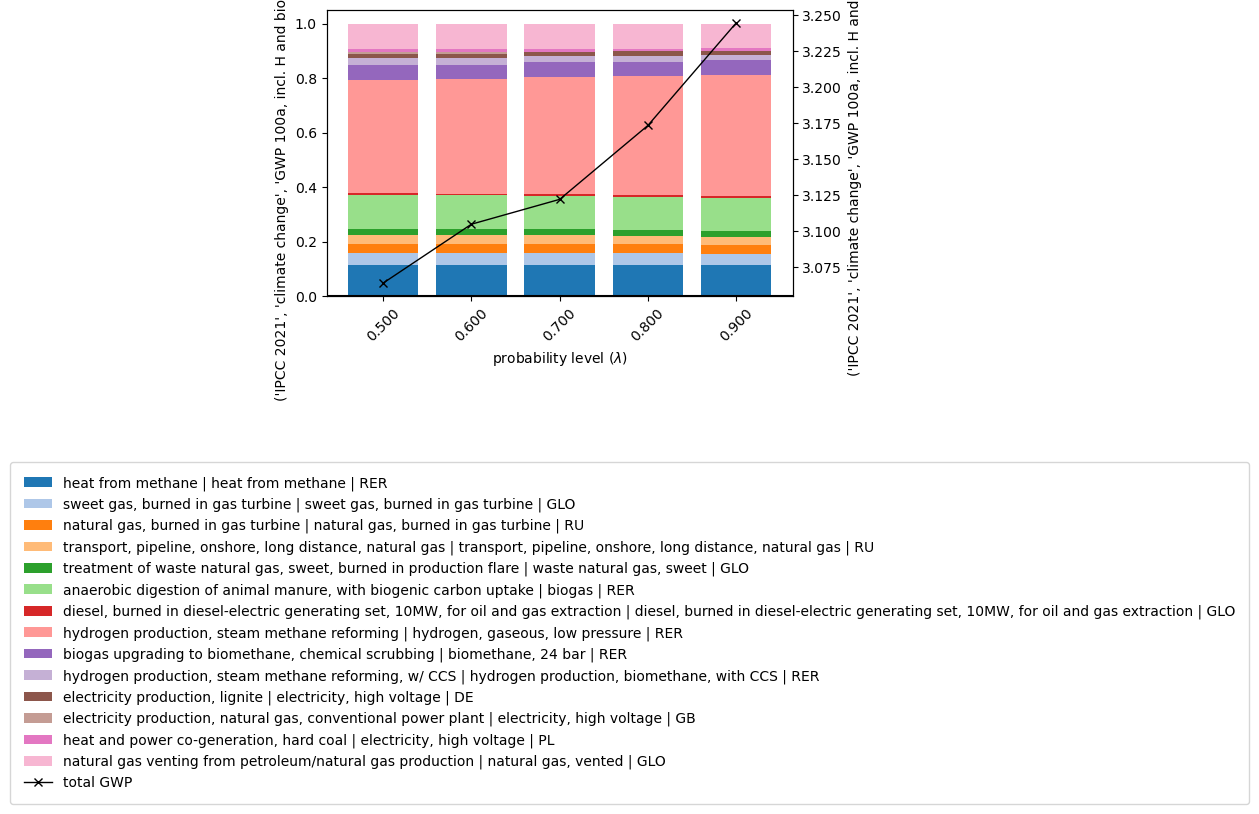

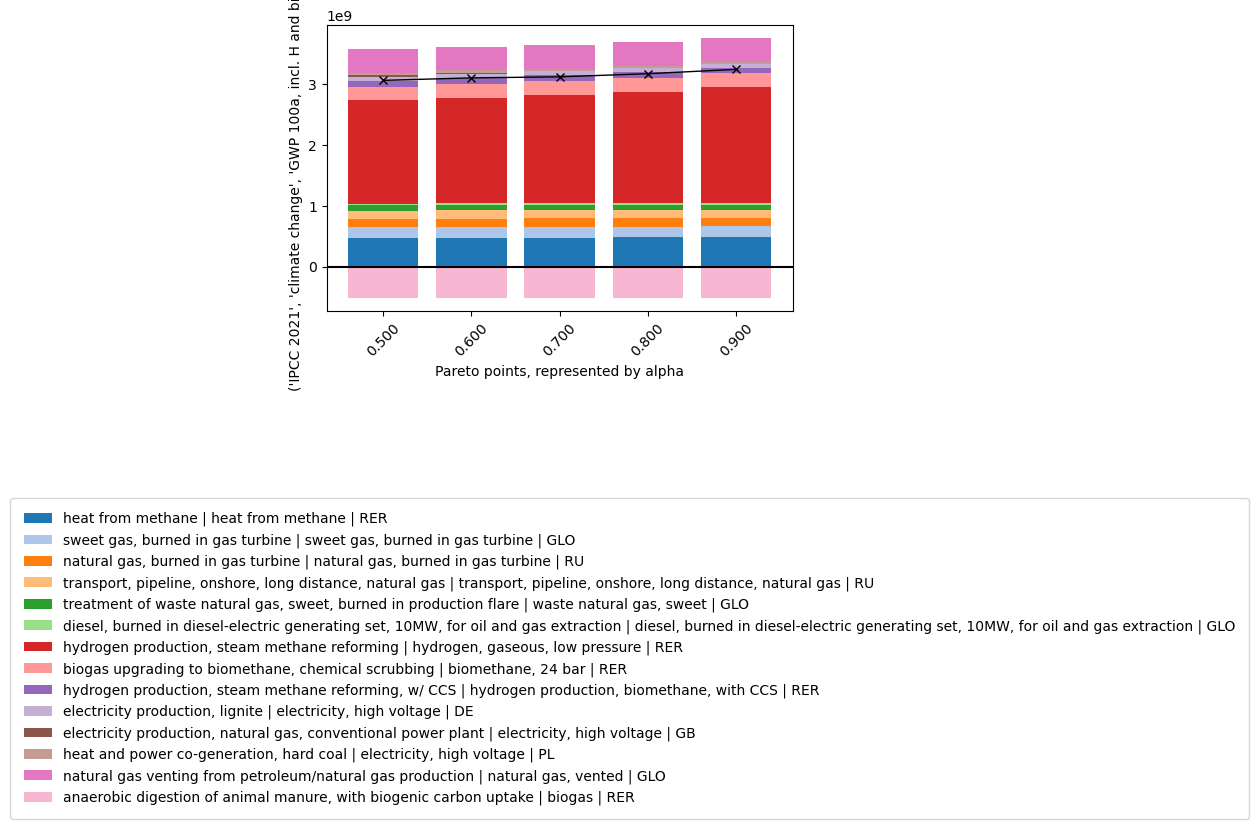

In [55]:
epsilon_pareto_solver_varbounds = pulpostats.EpsilonConstraintSolver(cc_varbounds_formulation)
lambda_epsilon_array = np.linspace(0.5,1, 5, endpoint=False)
CC_solutions_varbounds = epsilon_pareto_solver_varbounds.solve(lambda_epsilon_array)
epsilon_pareto_solver_varbounds.plot_pareto_front(CC_solutions_varbounds, 0.005, bbox_to_anchor=(0.65,-1.8))
epsilon_pareto_solver_varbounds.compare_subsequent_paretosolutions(CC_solutions_varbounds)


### 7.3. Chance constrain only the objective

solving CC problem for lambda_QB = 0.5
Running HiGHS 1.8.0 (git hash: eda5cbe): Copyright (c) 2024 HiGHS under MIT licence terms
Cols:       47102 lower bounds    less than or equal to       -1e+20 are treated as -Infinity
Cols:       47102 upper bounds greater than or equal to        1e+20 are treated as +Infinity
Rows:       23537 lower bounds    less than or equal to       -1e+20 are treated as -Infinity
Rows:       23537 upper bounds greater than or equal to        1e+20 are treated as +Infinity
optimal solution found:  4233595724.8767753
solving CC problem for lambda_QB = 0.6
Running HiGHS 1.8.0 (git hash: eda5cbe): Copyright (c) 2024 HiGHS under MIT licence terms
Cols:       47102 lower bounds    less than or equal to       -1e+20 are treated as -Infinity
Cols:       47102 upper bounds greater than or equal to        1e+20 are treated as +Infinity
Rows:       23537 lower bounds    less than or equal to       -1e+20 are treated as -Infinity
Rows:       23537 upper bounds greater t

'ammonia'

,Capacity,0.5,0.6,0.7,0.8,0.9
Metadata,,,,,,
"ammonia production, from nitrogen and hydrogen | ammonia production, from nitrogen and hydrogen | RER",1.000000e+20,2.010086e+09,2.010086e+09,2.010086e+09,2.010080e+09,2.010080e+09
"ammonia production, steam methane reforming | ammonia production, biomethane | RER",1.000000e+20,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00


'methane_market'

,Capacity,0.5,0.6,0.7,0.8,0.9
Metadata,,,,,,
"market group for natural gas, high pressure | natural gas, high pressure | Europe without Switzerland",1.000000e+20,2.074546e+09,2.074546e+09,2.074546e+09,2.228223e+09,2.228223e+09
market for bio methane | methane | RER,1.000000e+20,2.091992e+08,2.091992e+08,2.091992e+08,5.356957e+07,5.356957e+07


'hydrogen_market'

,Capacity,0.5,0.6,0.7,0.8,0.9
Metadata,,,,,,
"market for hydrogen, gaseous, low pressure | hydrogen, gaseous, low pressure | RER",1.000000e+20,2.527092e+08,2.527092e+08,2.527092e+08,2.527082e+08,2.527082e+08
market for hydrogen | hydrogen | RER,1.000000e+20,1.010667e+08,1.010667e+08,1.010667e+08,1.010667e+08,1.010667e+08


'ammonia_market'

,Capacity,0.5,0.6,0.7,0.8,0.9
Metadata,,,,,,
market for ammonia | ammonia | RER,1.000000e+20,3.000128e+09,3.000128e+09,3.000128e+09,3.000120e+09,3.000120e+09
"market for ammonia, anhydrous, liquid | ammonia, anhydrous, liquid | RER",1.000000e+20,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00


'hydrogen'

,Capacity,0.5,0.6,0.7,0.8,0.9
Metadata,,,,,,
"hydrogen production, steam methane reforming, w/ CCS | hydrogen production, biomethane, with CCS | RER",1.500000e+08,1.008642e+08,1.008642e+08,1.008642e+08,1.008642e+08,1.008642e+08
"hydrogen production, plastics gasification, w/ CCS | hydrogen production, plastics gasification, with CCS | RER",3.000000e+05,2.025361e+05,2.025361e+05,2.025361e+05,2.025361e+05,2.025361e+05
"hydrogen production, PEM electrolysis, yellow | hydrogen production, PEM electrolysis, green | RER",3.000000e+07,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00
"hydrogen production, steam methane reforming fg | hydrogen production, biomethane | RER",1.000000e+20,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00
"hydrogen production, plastics gasification | hydrogen production, plastics gasification | RER",1.200000e+07,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00


'heat'

,Capacity,0.5,0.6,0.7,0.8,0.9
Metadata,,,,,,
heat from methane | heat from methane | RER,1.000000e+20,8.223652e+09,8.223652e+09,8.223652e+09,8.223626e+09,8.223626e+09
"heat from methane, w/ CCS | heat from biomethane, with CCS | RER",1.400000e+09,1.031164e+09,1.031164e+09,1.031164e+09,1.031164e+09,1.031164e+09
heat from hydrogen | heat from hydrogen | RER,1.400000e+10,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00


'biomethane'

,Capacity,0.5,0.6,0.7,0.8,0.9
Metadata,,,,,,
"biogas upgrading to biomethane, chemical scrubbing | biomethane, 24 bar | RER",1.000000e+20,1.540733e+08,1.540733e+08,1.540733e+08,-0.000000e+00,-0.000000e+00
"biogas upgrading to biomethane, chemical scrubbing w/ CCS | biomethane, 24 bar | RER",3.600000e+07,2.715445e+07,2.715445e+07,2.715445e+07,2.715445e+07,2.715445e+07
"biogas upgrading to biomethane, water scrubbing w/ CCS | biomethane, 24 bar | RER",3.600000e+07,2.587942e+07,2.587942e+07,2.587942e+07,2.587942e+07,2.587942e+07
"biogas upgrading to biomethane, water scrubbing | biomethane, 24 bar | RER",1.000000e+20,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00


lambda_1: 0.5
lambda_2: 0.6

Amount of process scaling variables that changed:
213: >1% 
152: >10%
49: >100%
15: >1000%

Amount of process characterized scaling variables (impacts per process) that changed:
0: >1% 
0: >10%
0: >100%
0: >1000%

6.03993e-11: is the maximum impact change in one process
5.50238e-10: is the total impact change

The relative change of the characterized scaling vector (s_lambda_1 - s_lambda_2)*QB_s / QBs:



ID
electricity production, hard coal, conventional | electricity, high voltage | ZA                                         6.039932e-11
diesel, burned in diesel-electric generating set, 10MW | diesel, burned in diesel-electric generating set, 10MW | GLO    3.130199e-11
wafer production, fabricated, for integrated circuit | wafer, fabricated, for integrated circuit | GLO                   2.299306e-11
polymethyl methacrylate production, sheet | polymethyl methacrylate, sheet | RoW                                         2.194059e-11
hydrogen production, steam methane reforming | hydrogen, gaseous, low pressure | RoW                                     2.137999e-11
transport, freight, lorry >32 metric ton, EURO4 | transport, freight, lorry >32 metric ton, EURO4 | RoW                  1.370770e-11
polymethyl methacrylate production, sheet | polymethyl methacrylate, sheet | RER                                         1.085679e-11
maize grain production | maize grain | US-IA               


---

lambda_1: 0.6
lambda_2: 0.7

Amount of process scaling variables that changed:
491: >1% 
438: >10%
354: >100%
316: >1000%

Amount of process characterized scaling variables (impacts per process) that changed:
0: >1% 
0: >10%
0: >100%
0: >1000%

3.66319e-11: is the maximum impact change in one process
8.28471e-10: is the total impact change

The relative change of the characterized scaling vector (s_lambda_1 - s_lambda_2)*QB_s / QBs:



ID
electricity production, hard coal | electricity, high voltage | RoW                                                      3.663189e-11
hard coal mine operation and hard coal preparation | hard coal | CN                                                      2.937522e-11
wafer production, fabricated, for integrated circuit | wafer, fabricated, for integrated circuit | GLO                   2.088035e-11
polymethyl methacrylate production, sheet | polymethyl methacrylate, sheet | RoW                                         2.042813e-11
diesel, burned in diesel-electric generating set, 10MW | diesel, burned in diesel-electric generating set, 10MW | GLO    1.871950e-11
linseed seed production, at farm | linseed seed, at farm | RoW                                                           1.705800e-11
electricity production, hard coal | electricity, high voltage | CN-NM                                                    1.577551e-11
electricity production, hard coal | electricity, high volta


---

lambda_1: 0.7
lambda_2: 0.8

Amount of process scaling variables that changed:
14375: >1% 
5064: >10%
48: >100%
11: >1000%

Amount of process characterized scaling variables (impacts per process) that changed:
2: >1% 
0: >10%
0: >100%
0: >1000%

5.20037e-02: is the maximum impact change in one process
1.41939e-01: is the total impact change

The relative change of the characterized scaling vector (s_lambda_1 - s_lambda_2)*QB_s / QBs:



ID
anaerobic digestion of animal manure, with biogenic carbon uptake | biogas | RER                                                                              0.052004
biogas upgrading to biomethane, chemical scrubbing | biomethane, 24 bar | RER                                                                                 0.051619
natural gas venting from petroleum/natural gas production | natural gas, vented | GLO                                                                         0.004863
natural gas, burned in gas turbine | natural gas, burned in gas turbine | RU                                                                                  0.002849
softwood forestry, mixed species, sustainable forest management | sawlog and veneer log, softwood, measured as solid wood under bark | CH                     0.002209
sweet gas, burned in gas turbine | sweet gas, burned in gas turbine | GLO                                                                                     0.00


---

lambda_1: 0.8
lambda_2: 0.9

Amount of process scaling variables that changed:
408: >1% 
374: >10%
336: >100%
299: >1000%

Amount of process characterized scaling variables (impacts per process) that changed:
0: >1% 
0: >10%
0: >100%
0: >1000%

2.25835e-10: is the maximum impact change in one process
1.13961e-09: is the total impact change

The relative change of the characterized scaling vector (s_lambda_1 - s_lambda_2)*QB_s / QBs:



ID
sugarcane processing, traditional annexed plant | ethanol, without water, in 95% solution state, from fermentation | RoW    2.258348e-10
sugarcane production | sugarcane | IN                                                                                       1.509702e-10
sugarcane production | sugarcane | RoW                                                                                      1.301138e-10
electricity production, hard coal, conventional | electricity, high voltage | ZA                                            4.018650e-11
sugarcane production | sugarcane | BR-SP                                                                                    3.380309e-11
ethanol production from wood | ethanol, without water, in 95% solution state, from fermentation | RoW                       3.010161e-11
hard coal mine operation and hard coal preparation | hard coal | CN                                                         1.981093e-11
hydrogen production, steam methane ref


---



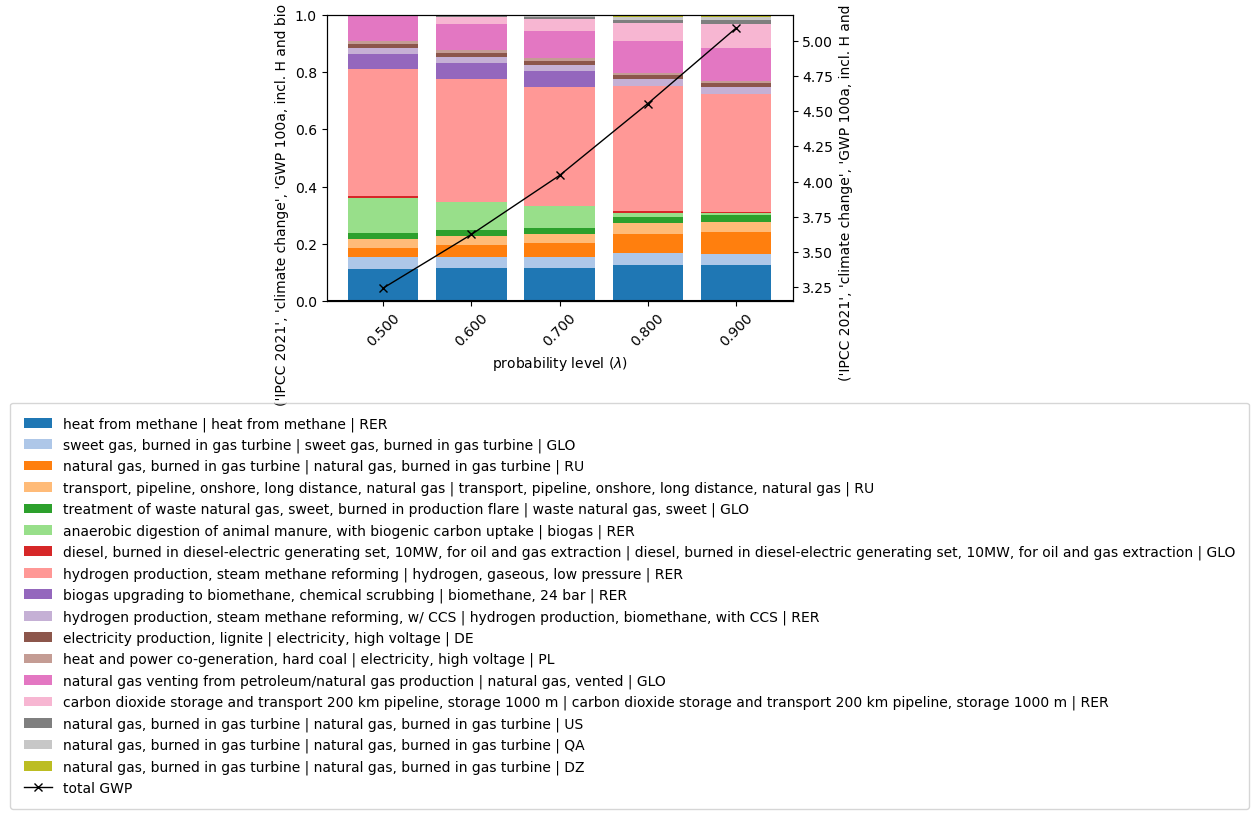

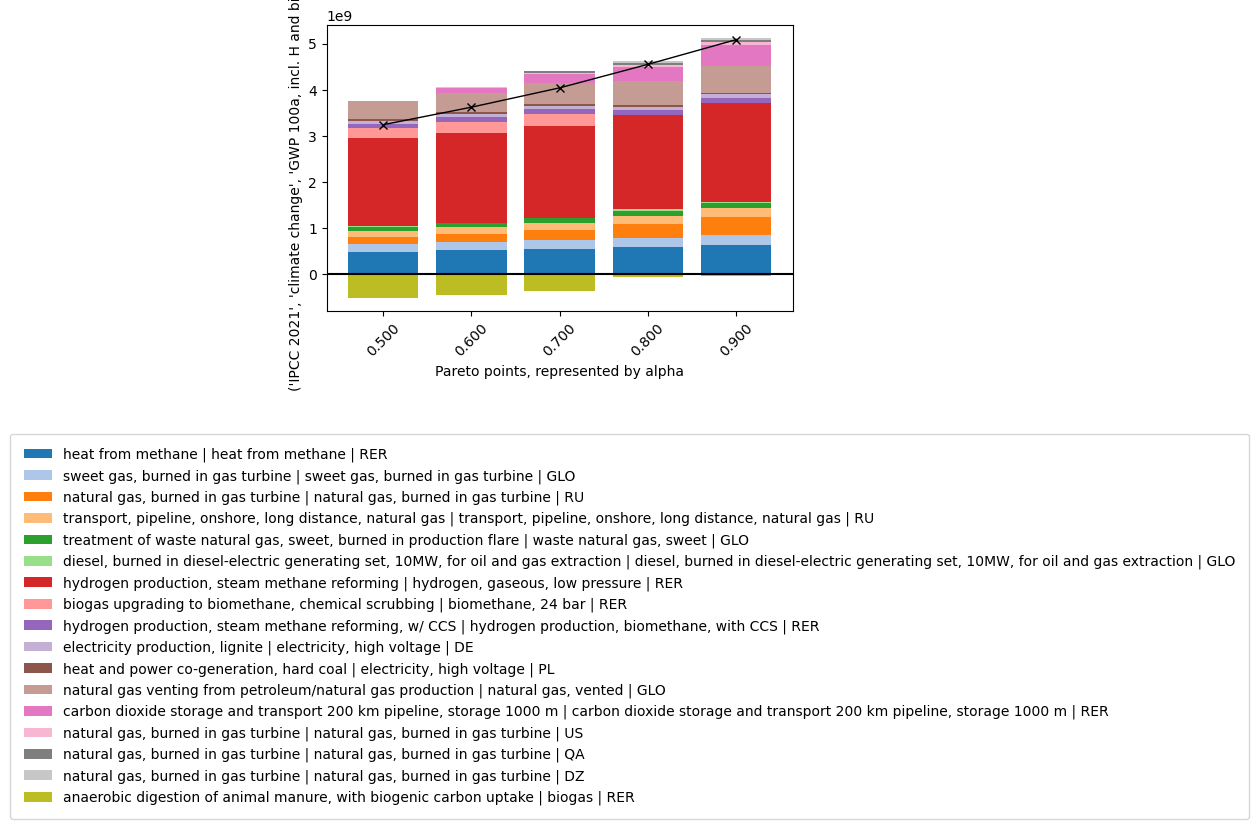

In [56]:
epsilon_pareto_solver_Obj = pulpostats.EpsilonConstraintSolver(cc_Obj_formulation)
lambda_epsilon_array = np.linspace(0.5,1, 5, endpoint=False)
CC_solutions_Obj = epsilon_pareto_solver_Obj.solve(lambda_epsilon_array)
epsilon_pareto_solver_Obj.plot_pareto_front(CC_solutions_Obj, 0.005, bbox_to_anchor=(0.65,-1.8))
epsilon_pareto_solver_Obj.compare_subsequent_paretosolutions(CC_solutions_Obj)

### 7.4. Chance constrain both the objective and the variable bounds

solving CC problem for lambda_QB = 0.5
Running HiGHS 1.8.0 (git hash: eda5cbe): Copyright (c) 2024 HiGHS under MIT licence terms
Cols:       47102 lower bounds    less than or equal to       -1e+20 are treated as -Infinity
Cols:       47102 upper bounds greater than or equal to        1e+20 are treated as +Infinity
Rows:       23537 lower bounds    less than or equal to       -1e+20 are treated as -Infinity
Rows:       23537 upper bounds greater than or equal to        1e+20 are treated as +Infinity
optimal solution found:  4037195072.3043594
solving CC problem for lambda_QB = 0.6
Running HiGHS 1.8.0 (git hash: eda5cbe): Copyright (c) 2024 HiGHS under MIT licence terms
Cols:       47102 lower bounds    less than or equal to       -1e+20 are treated as -Infinity
Cols:       47102 upper bounds greater than or equal to        1e+20 are treated as +Infinity
Rows:       23537 lower bounds    less than or equal to       -1e+20 are treated as -Infinity
Rows:       23537 upper bounds greater t

'ammonia'

,Capacity,0.5,0.6,0.7,0.8,0.9
Metadata,,,,,,
"ammonia production, from nitrogen and hydrogen | ammonia production, from nitrogen and hydrogen | RER",1.000000e+20,2.010086e+09,2.010086e+09,2.010086e+09,2.010081e+09,2.010080e+09
"ammonia production, steam methane reforming | ammonia production, biomethane | RER",1.000000e+20,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00


'methane_market'

,Capacity,0.5,0.6,0.7,0.8,0.9
Metadata,,,,,,
"market group for natural gas, high pressure | natural gas, high pressure | Europe without Switzerland",1.000000e+20,2.086223e+09,2.083918e+09,2.081451e+09,2.228620e+09,2.228235e+09
market for bio methane | methane | RER,1.000000e+20,2.092083e+08,2.092065e+08,2.092046e+08,5.724058e+07,5.357323e+07


'hydrogen_market'

,Capacity,0.5,0.6,0.7,0.8,0.9
Metadata,,,,,,
"market for hydrogen, gaseous, low pressure | hydrogen, gaseous, low pressure | RER",1.000000e+20,2.252433e+08,2.306661e+08,2.364678e+08,2.432568e+08,2.526732e+08
market for hydrogen | hydrogen | RER,1.000000e+20,1.285326e+08,1.231098e+08,1.173081e+08,1.105182e+08,1.011017e+08


'ammonia_market'

,Capacity,0.5,0.6,0.7,0.8,0.9
Metadata,,,,,,
market for ammonia | ammonia | RER,1.000000e+20,3.000128e+09,3.000128e+09,3.000128e+09,3.000120e+09,3.000120e+09
"market for ammonia, anhydrous, liquid | ammonia, anhydrous, liquid | RER",1.000000e+20,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00


'hydrogen'

,Capacity,0.5,0.6,0.7,0.8,0.9
Metadata,,,,,,
"hydrogen production, steam methane reforming, w/ CCS | hydrogen production, biomethane, with CCS | RER",1.500000e+08,1.282757e+08,1.228637e+08,1.170735e+08,1.102970e+08,1.008993e+08
"hydrogen production, plastics gasification, w/ CCS | hydrogen production, plastics gasification, with CCS | RER",3.000000e+05,2.568529e+05,2.461041e+05,2.346041e+05,2.211454e+05,2.024805e+05
"hydrogen production, PEM electrolysis, yellow | hydrogen production, PEM electrolysis, green | RER",3.000000e+07,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00
"hydrogen production, steam methane reforming fg | hydrogen production, biomethane | RER",1.000000e+20,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00
"hydrogen production, plastics gasification | hydrogen production, plastics gasification | RER",1.200000e+07,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00


'heat'

,Capacity,0.5,0.6,0.7,0.8,0.9
Metadata,,,,,,
heat from methane | heat from methane | RER,1.000000e+20,8.018146e+09,8.058829e+09,8.102356e+09,8.153270e+09,8.223915e+09
"heat from methane, w/ CCS | heat from biomethane, with CCS | RER",1.400000e+09,1.236671e+09,1.195987e+09,1.152461e+09,1.101520e+09,1.030875e+09
heat from hydrogen | heat from hydrogen | RER,1.400000e+10,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00


'biomethane'

,Capacity,0.5,0.6,0.7,0.8,0.9
Metadata,,,,,,
"biogas upgrading to biomethane, chemical scrubbing | biomethane, 24 bar | RER",1.000000e+20,1.435023e+08,1.455913e+08,1.478264e+08,-0.000000e+00,-0.000000e+00
"biogas upgrading to biomethane, chemical scrubbing w/ CCS | biomethane, 24 bar | RER",3.600000e+07,3.208461e+07,3.110956e+07,3.006637e+07,2.884549e+07,2.715235e+07
"biogas upgrading to biomethane, water scrubbing w/ CCS | biomethane, 24 bar | RER",3.600000e+07,3.152934e+07,3.041355e+07,2.921978e+07,2.782268e+07,2.588515e+07
"biogas upgrading to biomethane, water scrubbing | biomethane, 24 bar | RER",1.000000e+20,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00


lambda_1: 0.5
lambda_2: 0.6

Amount of process scaling variables that changed:
1133: >1% 
139: >10%
47: >100%
10: >1000%

Amount of process characterized scaling variables (impacts per process) that changed:
1: >1% 
0: >10%
0: >100%
0: >1000%

1.01201e-02: is the maximum impact change in one process
1.39290e-02: is the total impact change

The relative change of the characterized scaling vector (s_lambda_1 - s_lambda_2)*QB_s / QBs:



ID
hydrogen production, steam methane reforming | hydrogen, gaseous, low pressure | RER                                                                 0.010120
hydrogen production, steam methane reforming, w/ CCS | hydrogen production, biomethane, with CCS | RER                                               0.001121
biogas upgrading to biomethane, chemical scrubbing | biomethane, 24 bar | RER                                                                        0.000776
heat from methane | heat from methane | RER                                                                                                          0.000595
biogas upgrading to biomethane, water scrubbing w/ CCS | biomethane, 24 bar | RER                                                                    0.000125
carbon dioxide storage and transport 200 km pipeline, storage 1000 m | carbon dioxide storage and transport 200 km pipeline, storage 1000 m | RER    0.000114
heat from methane, w/ CCS | heat from biomethane,


---

lambda_1: 0.6
lambda_2: 0.7

Amount of process scaling variables that changed:
1511: >1% 
428: >10%
339: >100%
303: >1000%

Amount of process characterized scaling variables (impacts per process) that changed:
0: >1% 
0: >10%
0: >100%
0: >1000%

9.87159e-03: is the maximum impact change in one process
1.41475e-02: is the total impact change

The relative change of the characterized scaling vector (s_lambda_1 - s_lambda_2)*QB_s / QBs:



ID
hydrogen production, steam methane reforming | hydrogen, gaseous, low pressure | RER                                                                 0.009872
hydrogen production, steam methane reforming, w/ CCS | hydrogen production, biomethane, with CCS | RER                                               0.001162
biogas upgrading to biomethane, chemical scrubbing | biomethane, 24 bar | RER                                                                        0.000795
heat from methane | heat from methane | RER                                                                                                          0.000604
carbon dioxide storage and transport 200 km pipeline, storage 1000 m | carbon dioxide storage and transport 200 km pipeline, storage 1000 m | RER    0.000498
biogas upgrading to biomethane, water scrubbing w/ CCS | biomethane, 24 bar | RER                                                                    0.000126
heat from methane, w/ CCS | heat from biomethane,


---

lambda_1: 0.7
lambda_2: 0.8

Amount of process scaling variables that changed:
14346: >1% 
4896: >10%
64: >100%
11: >1000%

Amount of process characterized scaling variables (impacts per process) that changed:
3: >1% 
0: >10%
0: >100%
0: >1000%

5.18765e-02: is the maximum impact change in one process
1.54804e-01: is the total impact change

The relative change of the characterized scaling vector (s_lambda_1 - s_lambda_2)*QB_s / QBs:



ID
anaerobic digestion of animal manure, with biogenic carbon uptake | biogas | RER                                                             0.051876
biogas upgrading to biomethane, chemical scrubbing | biomethane, 24 bar | RER                                                                0.050602
hydrogen production, steam methane reforming | hydrogen, gaseous, low pressure | RER                                                         0.010601
natural gas venting from petroleum/natural gas production | natural gas, vented | GLO                                                        0.004817
natural gas, burned in gas turbine | natural gas, burned in gas turbine | RU                                                                 0.002783
softwood forestry, mixed species, sustainable forest management | sawlog and veneer log, softwood, measured as solid wood under bark | CH    0.002209
sweet gas, burned in gas turbine | sweet gas, burned in gas turbine | GLO                        


---

lambda_1: 0.8
lambda_2: 0.9

00{"name":"Exception","message":"not_supported","stack":["Traceback \u001b(most recent call last)\u001b:\n","\u001b  File \u001b<string>:174\u001b in \u001b__DW_DEBUG_WRAPPER__\u001b\n","\u001b  File \u001b<string>:165\u001b in \u001b__DW_GET_EXPRESSION_VARIABLE__\u001b\n","\u001bException\u001b\u001b:\u001b not_supported\n"]}
00{"name":"Exception","message":"not_supported","stack":["Traceback \u001b(most recent call last)\u001b:\n","\u001b  File \u001b<string>:174\u001b in \u001b__DW_DEBUG_WRAPPER__\u001b\n","\u001b  File \u001b<string>:165\u001b in \u001b__DW_GET_EXPRESSION_VARIABLE__\u001b\n","\u001bException\u001b\u001b:\u001b not_supported\n"]}
00{"name":"Exception","message":"not_supported","stack":["Traceback \u001b(most recent call last)\u001b:\n","\u001b  File \u001b<string>:174\u001b in \u001b__DW_DEBUG_WRAPPER__\u001b\n","\u001b  File \u001b<string>:165\u001b in \u001b__DW_GET_EXPRESSION_VARIABLE__\u001b\n","\u001bException\u001b\u001b:\u00

ID
hydrogen production, steam methane reforming | hydrogen, gaseous, low pressure | RER                                                                 0.013654
carbon dioxide storage and transport 200 km pipeline, storage 1000 m | carbon dioxide storage and transport 200 km pipeline, storage 1000 m | RER    0.001842
hydrogen production, steam methane reforming, w/ CCS | hydrogen production, biomethane, with CCS | RER                                               0.001811
heat from methane | heat from methane | RER                                                                                                          0.000907
anaerobic digestion of animal manure, with biogenic carbon uptake | biogas | RER                                                                     0.000838
biogas upgrading to biomethane, water scrubbing w/ CCS | biomethane, 24 bar | RER                                                                    0.000187
heat from methane, w/ CCS | heat from biomethane,


---

00{"name":"Exception","message":"not_supported","stack":["Traceback \u001b(most recent call last)\u001b:\n","\u001b  File \u001b<string>:174\u001b in \u001b__DW_DEBUG_WRAPPER__\u001b\n","\u001b  File \u001b<string>:165\u001b in \u001b__DW_GET_EXPRESSION_VARIABLE__\u001b\n","\u001bException\u001b\u001b:\u001b not_supported\n"]}
00{"name":"Exception","message":"not_supported","stack":["Traceback \u001b(most recent call last)\u001b:\n","\u001b  File \u001b<string>:174\u001b in \u001b__DW_DEBUG_WRAPPER__\u001b\n","\u001b  File \u001b<string>:165\u001b in \u001b__DW_GET_EXPRESSION_VARIABLE__\u001b\n","\u001bException\u001b\u001b:\u001b not_supported\n"]}
00{"name":"Exception","message":"not_supported","stack":["Traceback \u001b(most recent call last)\u001b:\n","\u001b  File \u001b<string>:174\u001b in \u001b__DW_DEBUG_WRAPPER__\u001b\n","\u001b  File \u001b<string>:165\u001b in \u001b__DW_GET_EXPRESSION_VARIABLE__\u001b\n","\u001bException\u001b\u001b:\u001b not_supported\n"]}
00{"nam

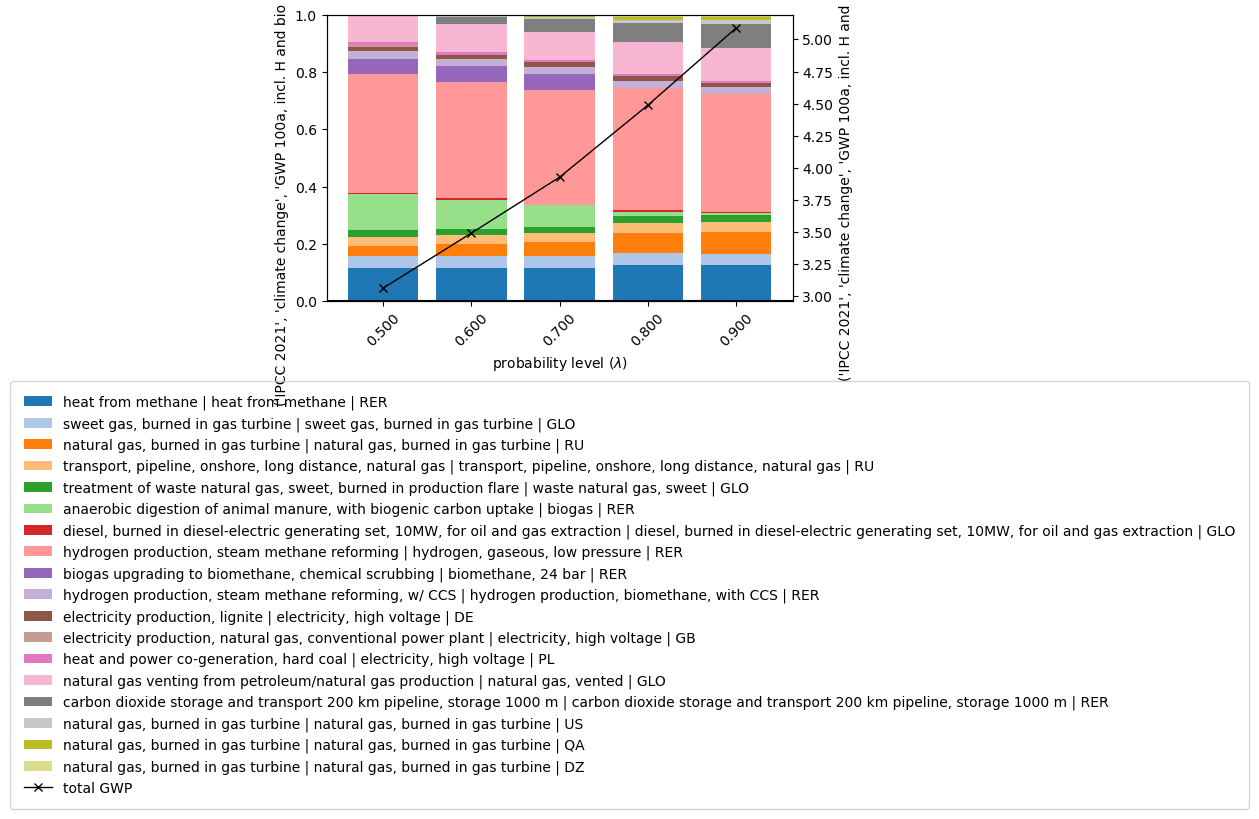

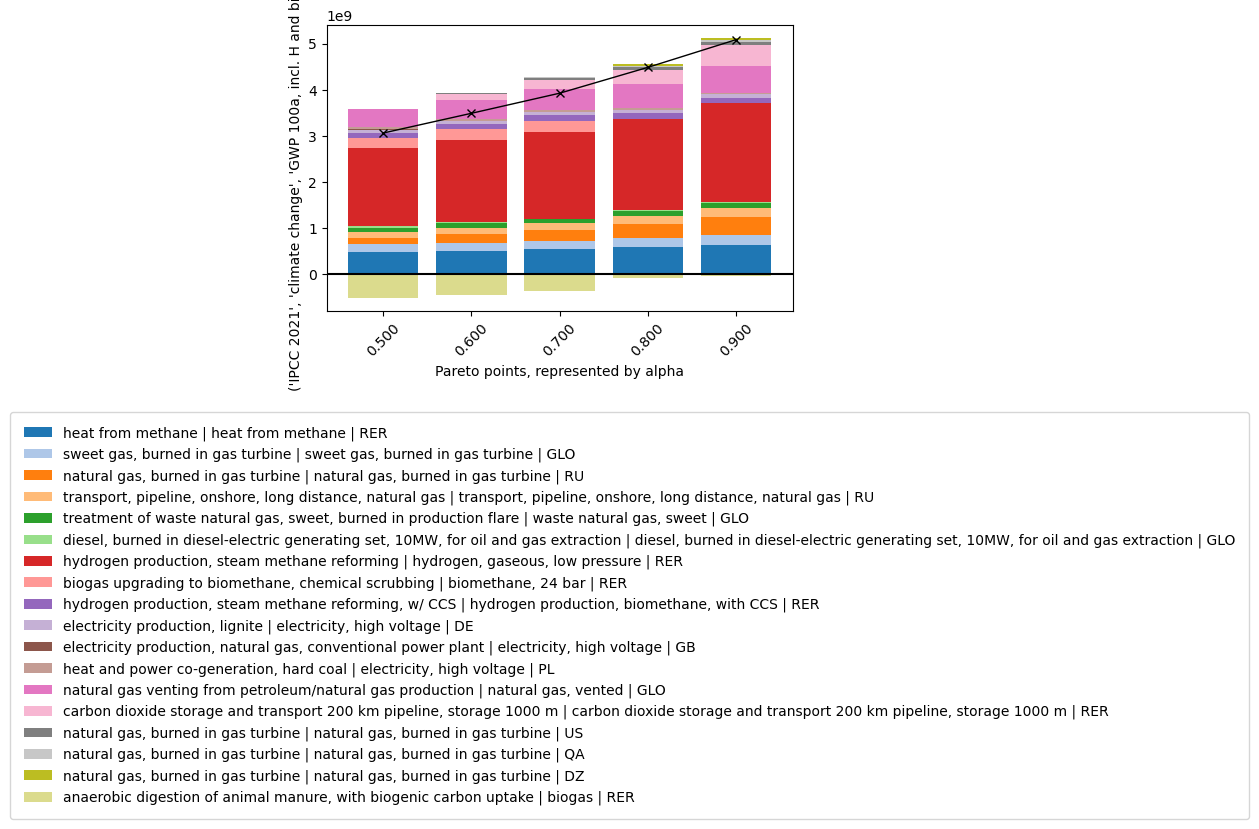

In [60]:
epsilon_pareto_solver_Obj_varbounds = pulpostats.EpsilonConstraintSolver(cc_Obj_varbounds_formulation)
lambda_epsilon_array = np.linspace(0.5,1, 5, endpoint=False)
CC_solutions_Obj_var_bounds = epsilon_pareto_solver_Obj_varbounds.solve(lambda_epsilon_array)
epsilon_pareto_solver_Obj_varbounds.plot_pareto_front(CC_solutions_Obj_var_bounds, 0.005, bbox_to_anchor=(0.65,-1.8))
epsilon_pareto_solver_Obj_varbounds.compare_subsequent_paretosolutions(CC_solutions_Obj_var_bounds)